In [299]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("MG31/aug_40", id2label={0:"license_plate"})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = DetrImageProcessor.from_pretrained("MG31/aug_40")

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Valid dataset 결과 확인

In [300]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

val_dataset = CocoDetection(img_folder=r"C:\Users\LMK\Desktop\aug2\val", processor=processor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [301]:
pixel_values, target = val_dataset[28] #0~49

In [302]:
print(pixel_values)
print(target)
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

tensor([[[ 2.0263,  2.0263,  2.0263,  ...,  2.2318,  2.2318,  2.2318],
         [ 2.0263,  2.0263,  2.0263,  ...,  2.2318,  2.2318,  2.2318],
         [ 2.0263,  2.0263,  2.0092,  ...,  2.2318,  2.2318,  2.2318],
         ...,
         [-0.4054, -0.4054, -0.4397,  ..., -0.9534, -0.9534, -0.9534],
         [-0.4568, -0.4568, -0.4911,  ..., -0.9534, -0.9534, -0.9534],
         [-0.4739, -0.4739, -0.4911,  ..., -0.9534, -0.9534, -0.9534]],

        [[ 1.6408,  1.6408,  1.5882,  ...,  2.4111,  2.4111,  2.4111],
         [ 1.6408,  1.6408,  1.5882,  ...,  2.4111,  2.4111,  2.4111],
         [ 1.6057,  1.6057,  1.5357,  ...,  2.4111,  2.4111,  2.4111],
         ...,
         [-0.4251, -0.4251, -0.4601,  ..., -0.8102, -0.8102, -0.8102],
         [-0.4776, -0.4776, -0.5126,  ..., -0.8102, -0.8102, -0.8102],
         [-0.4951, -0.4951, -0.5126,  ..., -0.8102, -0.8102, -0.8102]],

        [[ 0.2871,  0.2871,  0.2871,  ...,  2.6400,  2.6400,  2.6400],
         [ 0.2871,  0.2871,  0.2871,  ...,  2

In [303]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [304]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

[{'scores': tensor([0.9965], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'boxes': tensor([[ 91.7891, 161.1918, 128.5968, 181.6819]], device='cuda:0')}]


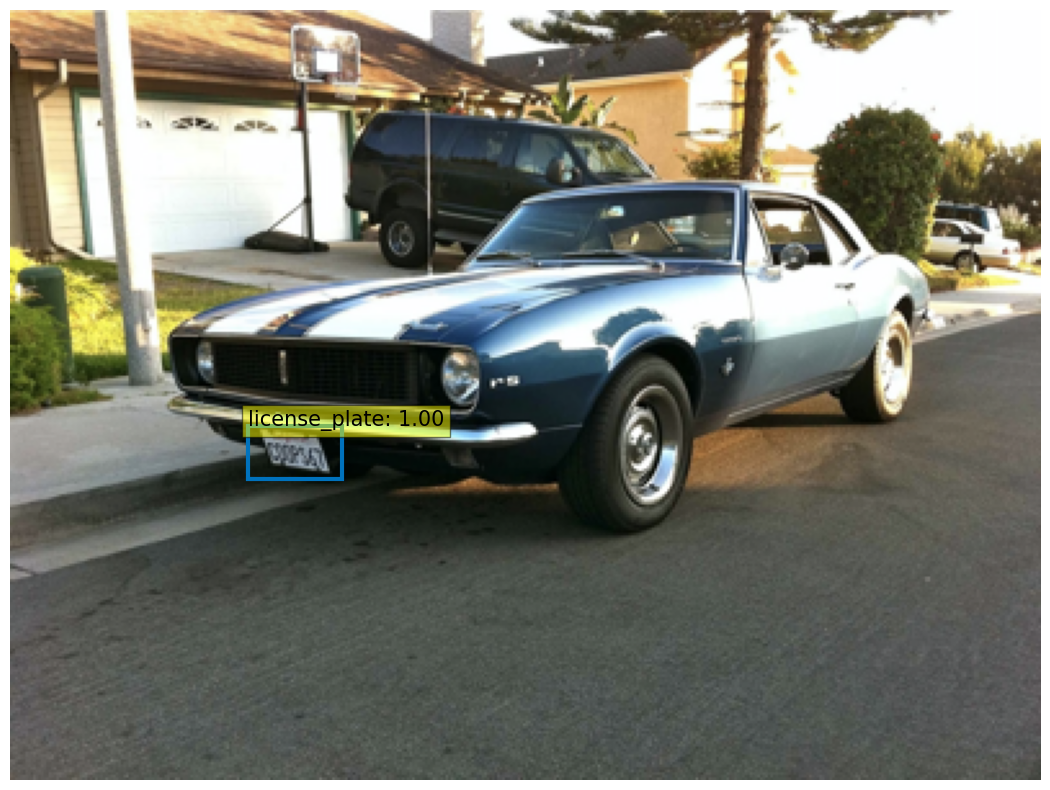

In [305]:
import PIL
from PIL import Image, ImageDraw, ImageFont
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(r"C:\Users\LMK\Desktop\archive\set_1\val", image['file_name']))
image = PIL.ImageOps.exif_transpose(image)

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.5)
results = postprocessed_outputs[0]
print(postprocessed_outputs)
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [306]:
import torchvision.transforms.functional as F

bbox = results['boxes'][0].tolist()
xmin, ymin, xmax, ymax = map(int, bbox)
cropped_image = image.crop((xmin, ymin, xmax, ymax))
cropped_image

In [307]:
!pip install easyocr

In [308]:
import easyocr
import numpy as np
import re

reader = easyocr.Reader(['ko'])

In [309]:
result = reader.readtext(np.asarray(cropped_image))
for (bbox, text, prob) in result:
  text = re.sub(r'[^가-힣0-9]', '', text)
  print(text)

In [310]:
result

[]

# 실제 이미지로 인식

In [311]:
!pip install albumentations==1.1.0
!pip install opencv-python-headless
!pip install numpy
!pip install torch
!pip install matplotlib


In [322]:
import cv2
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

# Load pre-trained model and processor
processor_path = "MG31/aug_40"
model = DetrForObjectDetection.from_pretrained(processor_path, id2label={0:"license_plate"})
processor = DetrImageProcessor.from_pretrained(processor_path)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load and preprocess the image
input_image_path = r"C:\Users\LMK\Desktop\archive\car\1.jpg" 
input_image = cv2.imread(input_image_path)

# Convert BGR (OpenCV format) to RGB (expected by the model)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Encode the image
encoding = processor(images=input_image, return_tensors="pt")
pixel_values = encoding["pixel_values"]

# Move the input tensor to the same device as the model
pixel_values = pixel_values.to(device)

# Forward pass to get class logits and bounding boxes
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

# Print the outputs keys for debugging
print("Outputs:", outputs.keys())


Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [323]:
pixel_values.shape

torch.Size([1, 3, 800, 890])

In [324]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

[{'scores': tensor([0.9993], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'boxes': tensor([[ 832.9933, 1776.7323, 1527.0430, 1988.8131]], device='cuda:0')}]


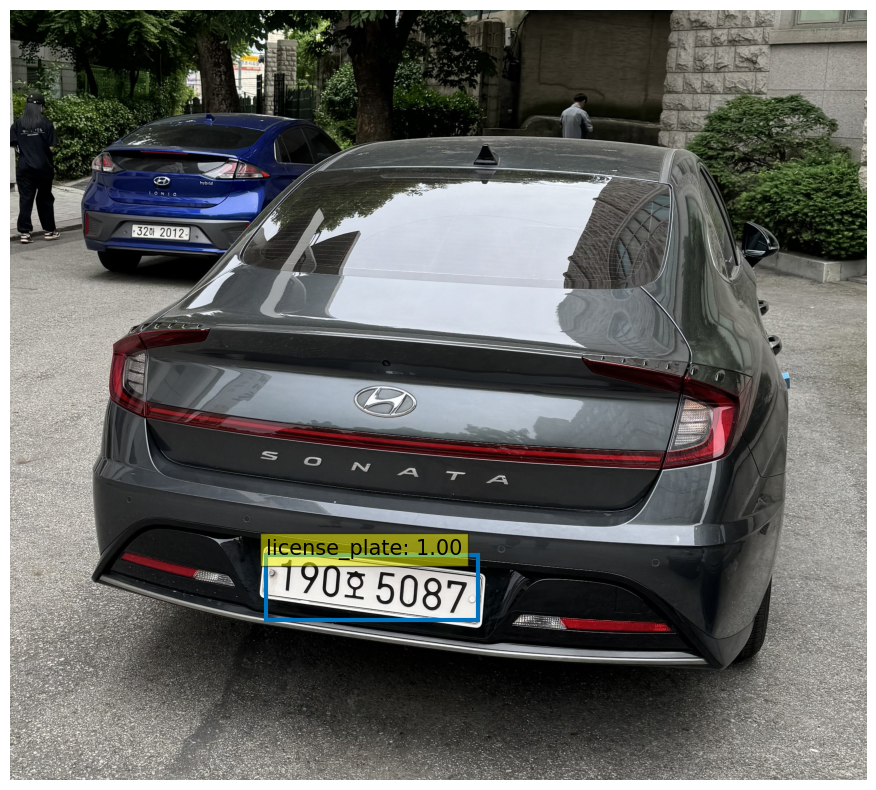

In [325]:
import PIL
from PIL import Image, ImageDraw, ImageFont

image = Image.open(input_image_path)
image = PIL.ImageOps.exif_transpose(image)

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.5)
results = postprocessed_outputs[0]
print(postprocessed_outputs)
plot_results(image, results['scores'], results['labels'], results['boxes'])

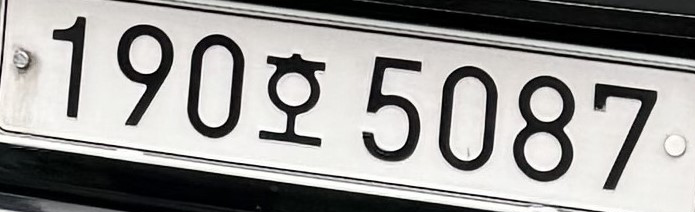

In [326]:
import torchvision.transforms.functional as F

bbox = results['boxes'][0].tolist()
xmin, ymin, xmax, ymax = map(int, bbox)
cropped_image = image.crop((xmin, ymin, xmax, ymax))
cropped_image

In [327]:
result = reader.readtext(np.asarray(cropped_image))
for (bbox, text, prob) in result:
  text = re.sub(r'[^가-힣0-9]', '', text)
  print(text)

7
90호
5087


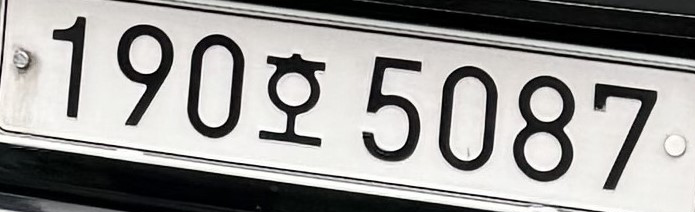

7
90호
5087


In [328]:
#신뢰도 가장 높은 번호판 선택
import PIL
from PIL import Image, ImageDraw
import numpy as np
import re
from IPython.display import display

# 이미지를 PIL 형식으로 열기
image = Image.open(input_image_path)

# 이미지 회전
image = PIL.ImageOps.exif_transpose(image)

# 후처리된 모델 출력 얻기
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs, target_sizes=[(height, width)], threshold=0.5)
results = postprocessed_outputs[0]

# 가장 높은 점수를 가진 객체의 인덱스 찾기
max_score_index = results['scores'].argmax().item()

# 가장 높은 점수를 가진 객체의 바운딩 박스 추출
bbox = results['boxes'][max_score_index].tolist()
xmin, ymin, xmax, ymax = map(int, bbox)

# 이미지에서 해당 바운딩 박스에 해당하는 부분 자르기
cropped_image = image.crop((xmin, ymin, xmax, ymax))

# 바운딩 박스를 원본 이미지에 표시하기 위한 이미지 복사
draw = ImageDraw.Draw(image)
draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)

# 중간 과정 이미지 보여주기
display(cropped_image)

# 이미지를 numpy 배열로 변환하고 텍스트 읽기
cropped_image_np = np.asarray(cropped_image)
result = reader.readtext(cropped_image_np)

# 텍스트 출력
for (bbox, text, prob) in result:
    text = re.sub(r'[^가-힣0-9]', '', text)
    print(text)


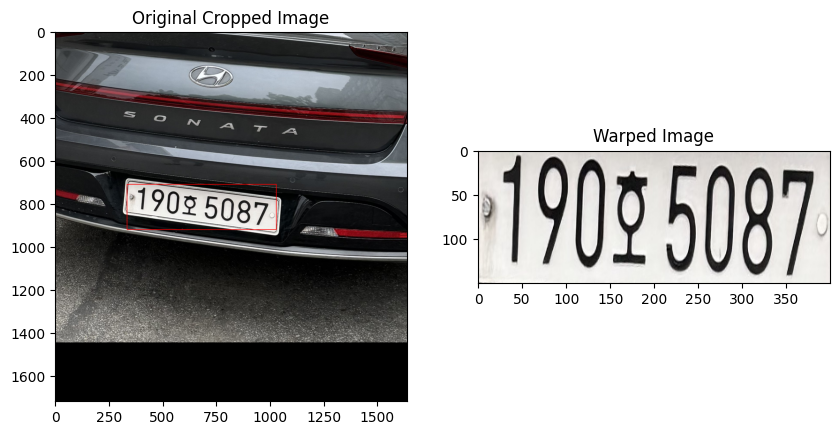

19025087


In [329]:
###
import numpy as np
import cv2
import re
import easyocr
from PIL import Image
import matplotlib.pyplot as plt

def order_points(pts):
    # 네 개의 좌표점을 초기화할 배열
    rect = np.zeros((4, 2), dtype="float32")

    # 좌표점 정렬: 순서대로 왼쪽 위, 오른쪽 위, 오른쪽 아래, 왼쪽 아래
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

# EasyOCR 리더 초기화
reader = easyocr.Reader(['ko', 'en'])


# 가장 높은 점수를 가진 객체의 인덱스 찾기
max_score_index = results['scores'].argmax().item()

# 가장 높은 점수를 가진 객체의 바운딩 박스 추출
bbox = results['boxes'][max_score_index].tolist()
xmin, ymin, xmax, ymax == map(int, bbox)


cropped_image = image.crop((xmin*0.6, ymin*0.6, xmax*1.4, ymax*1.4))

# 이미지를 OpenCV 형식으로 변환
open_cv_image = np.array(cropped_image)
open_cv_image = open_cv_image[:, :, ::-1].copy()  # RGB to BGR

# 그레이스케일 변환 및 블러링
gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 엣지 검출
edges = cv2.Canny(blurred, 50, 150)

# 컨투어 검출
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 가장 큰 컨투어 찾기
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None

for c in contours:
    # 컨투어의 근사치를 구함
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # 사각형 컨투어를 찾음
    if len(approx) == 4:
        screenCnt = approx
        break

# 컨투어가 발견되지 않으면 오류 발생
if screenCnt is None:
    raise Exception("Could not find contour")

# 원근 변환을 위한 꼭짓점 좌표 추출 및 정렬
pts = screenCnt.reshape(4, 2)
rect = order_points(pts)

# 변환 후 이미지에서의 꼭짓점 좌표
width, height = 400, 150  # 번호판의 가로와 세로 크기 비율에 맞게 지정
dst = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

# 원근 변환 행렬 계산
M = cv2.getPerspectiveTransform(rect, dst)

# 원근 변환 적용
warped = cv2.warpPerspective(open_cv_image, M, (width, height))

# 원근 변환된 이미지 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB))
plt.title('Original Cropped Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.show()

# 원근 변환된 이미지를 PIL 형식으로 변환
warped_image = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

# 원근 변환된 이미지를 OCR로 읽기
result = reader.readtext(np.asarray(warped_image))

# OCR 결과에서 텍스트 추출 및 필터링
for (bbox, text, prob) in result:
    text = re.sub(r'[^가-힣0-9]', '', text)
    print(text)


In [ ]:
####import numpy as init
import cv2
import re
import easyocr
from PIL import Image
import matplotlib.pyplot as plt

# 필요한 라이브러리들을 로드합니다.

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

# EasyOCR 리더 초기화
reader = easyocr.Reader(['ko', 'en'])

# 결과와 이미지를 불러오는 부분 필요 (여기에 코드 추가)

# 가장 높은 점수를 가진 객체의 인덱스 찾기
max_score_index = results['scores'].argmax().item()

# 가장 높은 점수를 가진 객체의 바운딩 박스 추출
bbox = results['boxes'][max_score_index].tolist()
xmin, ymin, xmax, ymax = map(int, bbox)  # 할당 연산자 수정

cropped_image = image.crop((xmin*0.6-20, ymin*0.6-20, xmax*1.4+20, ymax*1.4+20))

open_cv_image = np.array(cropped_image)
open_cv_image = open_cv_image[:, :, ::-1].copy()

gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edges = cv2.Canny(blurred, 50, 150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None

for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)

    if len(approx) == 4:
        screenCnt = approx
        break

if screenCnt is None:
    print("Could not find contour")
    # 여기서 처리를 중단하거나 다른 로직으로 넘어갑니다.
else:
    pts = screenCnt.reshape(4, 2)
    rect = order_points(pts)
    width, height = 400, 150
    dst = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(open_cv_image, M, (width, height))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Cropped Image')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title('Warped Image')
    plt.show()

    warped_image = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    result = reader.readtext(np.asarray(warped_image))

    for (bbox, text, prob) in result:
        text = re.sub(r'[^가-힣0-9]', '', text)
        print(text)


In [ ]:
pip install --user opencv-python


In [ ]:
import pytesseract

# Tesseract 설치 경로 설정
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [ ]:
import numpy as np
import cv2
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import re

# Tesseract 설치 경로 설정 (Tesseract 설치 후 경로 지정)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

# 가장 높은 점수를 가진 객체의 인덱스 찾기
max_score_index = results['scores'].argmax().item()

# 가장 높은 점수를 가진 객체의 바운딩 박스 추출
bbox = results['boxes'][max_score_index].tolist()
xmin, ymin, xmax, ymax = map(int, bbox)

cropped_image = image.crop((xmin*0.6, ymin*0.6, xmax*1.4, ymax*1.4))

# 이미지를 OpenCV 형식으로 변환
open_cv_image = np.array(cropped_image)
open_cv_image = open_cv_image[:, :, ::-1].copy()  # RGB to BGR

# 그레이스케일 변환 및 블러링
gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 적응형 임계처리 (Adaptive Thresholding)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 컨투어 검출
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 가장 큰 컨투어 찾기
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None

for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        screenCnt = approx
        break

if screenCnt is None:
    raise Exception("Could not find contour")

# 원근 변환을 위한 꼭짓점 좌표 추출 및 정렬
pts = screenCnt.reshape(4, 2)
rect = order_points(pts)

# 변환 후 이미지에서의 꼭짓점 좌표
width, height = 400, 150  # 번호판의 가로와 세로 크기 비율에 맞게 지정
dst = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

# 원근 변환 행렬 계산
M = cv2.getPerspectiveTransform(rect, dst)

# 원근 변환 적용
warped = cv2.warpPerspective(open_cv_image, M, (width, height))

# 원근 변환된 이미지 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB))
plt.title('Original Cropped Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.show()

# 원근 변환된 이미지를 PIL 형식으로 변환
warped_image = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

# 전처리 - 이진화
gray_warped = cv2.cvtColor(np.array(warped_image), cv2.COLOR_BGR2GRAY)
_, binary_warped = cv2.threshold(gray_warped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 이진화된 이미지를 PIL 형식으로 변환
binary_warped_image = Image.fromarray(binary_warped)

# Tesseract OCR로 읽기 (한글 및 영어 언어 설정)
custom_config = r'--oem 1 --psm 6 -l kor+eng'
text = pytesseract.image_to_string(binary_warped_image, config=custom_config)
text = re.sub(r'[^가-힣0-9]', '', text)
print(text)
